In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from math import radians, cos, sin, asin, sqrt
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error,auc

In [2]:
df=pd.read_csv('D:\\Code\\Python\\CSE475\\Dataset\\train.csv',nrows=1000000)

In [3]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   key                1000000 non-null  object 
 1   fare_amount        1000000 non-null  float64
 2   pickup_datetime    1000000 non-null  object 
 3   pickup_longitude   1000000 non-null  float64
 4   pickup_latitude    1000000 non-null  float64
 5   dropoff_longitude  999990 non-null   float64
 6   dropoff_latitude   999990 non-null   float64
 7   passenger_count    1000000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 61.0+ MB


In [5]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1000000.000000,1000000.000000,1000000.000000,999990.000000,999990.000000,1000000.000000
mean,11.348079,-72.526640,39.929008,-72.527860,39.919954,1.684924
std,9.822090,12.057937,7.626154,11.324494,8.201418,1.323911
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734046,1.000000
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000
75%,12.500000,-73.967094,40.767154,-73.963654,40.768129,2.000000
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,208.000000


In [6]:
df.isna().sum()

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    10
dropoff_latitude     10
passenger_count       0
dtype: int64

In [7]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S UTC')

In [8]:
df['Hour'] = df['pickup_datetime'].dt.hour
df['minute'] = df['pickup_datetime'].dt.minute
df['date'] = df['pickup_datetime'].dt.day
df['day'] = df['pickup_datetime'].dt.dayofweek
df['month'] = df['pickup_datetime'].dt.month
df['year'] = df['pickup_datetime'].dt.year

df['Hour'] = df['Hour'].astype('int64')
df['minute'] = df['minute'].astype('int64')
df['date'] = df['date'].astype('int64')
df['day'] = df['day'].astype('int64')
df['month'] = df['month'].astype('int64')
df['year'] = df['year'].astype('int64')

In [9]:
Q1 = df['passenger_count'].quantile(0.25)
Q3 = df['passenger_count'].quantile(0.75)

IQR = Q3 - Q1

lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR
print('Lower :',lower)
print('Upper :',upper)

Lower : -0.5
Upper : 3.5


In [10]:
df.drop(df[df['passenger_count'] > 4 ].index, inplace = True)
df.drop(df[df['passenger_count'] <= 0 ].index, inplace = True)
df.drop(df[df['passenger_count'].isna() ].index, inplace = True)

In [11]:
df.drop(df[df['fare_amount'] > 150 ].index, inplace = True)
df.drop(df[df['fare_amount'] <= 0 ].index, inplace = True)
df.drop(df[df['fare_amount'].isna() ].index, inplace = True)

In [12]:
df.drop(df[df['pickup_latitude'] > 90].index, inplace=True)
df.drop(df[df['pickup_latitude'] < -90].index, inplace=True)
df.drop(df[df['dropoff_latitude'] > 90].index, inplace=True)
df.drop(df[df['dropoff_latitude'] < -90].index, inplace=True) 

In [13]:
df.drop(df[df['pickup_longitude'] > 180].index, inplace=True)
df.drop(df[df['pickup_longitude'] < -180].index, inplace=True)
df.drop(df[df['dropoff_longitude'] > 180].index, inplace=True)
df.drop(df[df['dropoff_longitude'] < -180].index, inplace=True) 

In [14]:
def haversine(a):
    lon1=a[0]
    lat1=a[1]
    lon2=a[2]
    lat2=a[3]
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c =  2 * asin(sqrt(a))
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [15]:
df['distance'] = df[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']].apply(haversine,axis=1)

In [16]:
df.drop(['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], axis=1, inplace=True)

In [17]:
Q1 = df['distance'].quantile(0.25)
Q3 = df['distance'].quantile(0.75)

IQR = Q3 - Q1

lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR
print('Lower :',lower)
print('Upper :',upper)

Lower : -2.781745900211569
Upper : 7.875550394530679


In [18]:
df.drop(df[df['distance'] >= 130].index, inplace=True)
df.drop(df[df['distance'] <= 0 ].index, inplace=True)

In [19]:
df['passenger_count'] = df['passenger_count'].astype('int64')

<AxesSubplot:ylabel='passenger_count'>

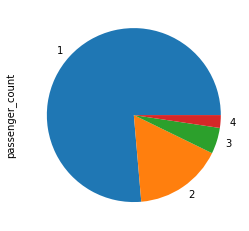

In [20]:
df["passenger_count"].value_counts().plot(kind="pie")

<AxesSubplot:>

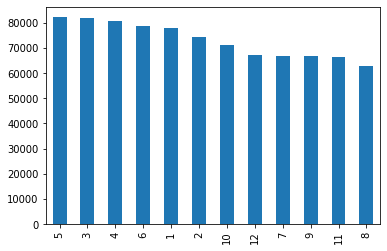

In [21]:
df["month"].value_counts().plot(kind="bar")

In [23]:
train, test= train_test_split(df, test_size = 0.2, random_state=42)

In [24]:
features=df.columns
features=[x for x in features if x!='fare_amount' and x!='pickup_datetime' and x!="key"]

In [25]:
X_train=train[features]
y_train=train[["fare_amount"]]

X_test=test[features]
y_test=test[["fare_amount"]]

In [26]:
# model = RandomForestRegressor(n_estimators=250)

In [27]:
# model.fit(X_train, y_train.values.ravel())

In [28]:
# y_pred = model.predict(X_test)

In [29]:
# model.score(X_train, y_train)

In [30]:
# r2=r2_score(y_test,y_pred)
# rmse=np.sqrt(mean_squared_error(y_test, y_pred))
# mae = mean_absolute_error(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
# print(f"R2: {r2_score}")
# print(f"MAE: {mae}")
# print(f"MSE: {mse}")
# print(f"RMSE: {rmse}")


In [31]:
model=DecisionTreeRegressor(max_depth=8)

In [32]:
model.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=8)

In [33]:
y_pred=model.predict(X_test)

In [34]:
r2=r2_score(y_test,y_pred)
rmse=np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R2: {r2}")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

R2: 0.8123366832636597
MAE: 2.072797765135644
MSE: 16.77881556323015
RMSE: 4.096195254529519


In [43]:
model=LinearRegression()

In [44]:
model.fit(X_train,y_train)

LinearRegression()

In [45]:
y_pred=model.predict(X_test)

In [46]:
r2=r2_score(y_test,y_pred)
rmse=np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R2: {r2}")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

R2: 0.5800666300741637
MAE: 2.668197184632549
MSE: 37.545881024423345
RMSE: 6.127469381761393
